In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [13]:
## !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 11 15:42:20 2020

@author: eceakcicek
"""
import math
from sklearn.metrics import accuracy_score
import time
import os, psutil
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import random
from sklearn.model_selection import train_test_split

################# MAIN GA FUNCTIONS
def init_population(n,c):
    return np.array([[math.ceil(e) for e in pop] for pop in (np.random.rand(n,c)-0.5)]), np.zeros((2,c))-1

def single_point_crossover(population):
    r,c = population.shape[0], population.shape[1]
    n = np.random.randint(1,c)     
    
    for i in range(0,r,2):                
        population[i], population[i+1] = np.append(population[i][0:n],population[i+1][n:c]),np.append(population[i+1][0:n],population[i][n:c])        
    return population

# does cross-over on 2 agents chosen by tournament
# replaces offsprings with least fit %50
def double_point_crossover(population, fitness):
    r,c = population.shape[0], population.shape[1]
    n1 = np.random.randint(1,c-1)  
    n2 = np.random.randint(n1,c)  
    # for i in range(0,r,2):
    for i in range(round(r/2)):
        g1 = tournament_selection(population, fitness)
        g2 = tournament_selection(population, fitness)
        #population[g1] = np.append(np.append(population[g1][0:n1],population[g2][n1:n2]), population[g1][n2:c])
        #population[g2] = np.append(np.append(population[g2][0:n1],population[g1][n1:n2]), population[g2][n2:c])        
        population[r-(i+1)] = np.append(np.append(population[g1][0:n1],population[g2][n1:n2]), population[g1][n2:c])
    return population

# cross over between elements which has lowest and highest accuracy and replace the lowest one
# takes sorted population
def minmax_double_point_crossover(population):
    r,c = population.shape[0]-1, population.shape[1]
    #for i in range(round(r/10)): 
    for i in range(1): 
        n1 = np.random.randint(1,c-1)  
        n2 = np.random.randint(n1,c) 
        population[r-i] = np.append(np.append(population[r-i][0:n1],population[i][n1:n2]), population[r-i][n2:c]) 
    return population

# selection by tournament to select parents for crossover
# returns the population[] index of champion
def tournament_selection(population, fitness):
    k = 5
    cand_fitness = []
    cand_fit_index = []
    candidates = random.choices(population, k=k)
    candidates = np.array(candidates)
    for i in range(k):
        for j in range(population.shape[0]):
            if (candidates[i] == population[j]).all():
                cand_fitness.append(fitness[j])
                cand_fit_index.append(j)
    champ = cand_fit_index[cand_fitness.index(max(cand_fitness))]
    return champ

"""
#UNUSED FUNCTIONS

def flip_mutation(population):
    return population.max() - population

# selects a random gene of a random element
# mutates it
def random_gene_mutation(population):
    r,c = population.shape[0], population.shape[1]
    element = np.random.randint(1,r)
    gene = np.random.randint(1,c)
    if population[element][gene] == 0:
        population[element][gene] = 1
    if population[element][gene] == 1:
        population[element][gene] = 0
    return population

# randomly selects an agent
# randomly selects a subset of genes
# shuffles values
def scrambled_mutation(population):
    r,c = population.shape[0], population.shape[1]
    #for i in range(round(r/5)):
    for i in range(r):
        element = np.random.randint(3,r)
        p1 = np.random.randint(1,(c-10))
        p2 = p1+10
        np.random.shuffle(population[element][p1:p2])
    return population
    
def random_selection(population):
    r = population.shape[0]
    new_population = population.copy()    
    for i in range(r):        
        new_population[i] = population[np.random.randint(0,r)]
    return new_population
"""

########################## GA ADDITIVE
    
def memorize(pop, memory):      
    return np.append(memory, pop.reshape(1,memory.shape[1]), axis=0)

def replace_duplicate(population, memory):    
    for i in range(population.shape[0]):         
        counter = 0                
        while population.shape[1] in sum((memory==population[i]).astype(int).T) and counter<100:                                
            population[i] = np.array([math.ceil(k) for k in (np.random.rand(population.shape[1])-0.5)])                    
            counter += 1                    
        memory = memorize(population[i], memory)        
    return population, memory

def sort_fitness_pop(fitness, population, accuracy):
    r = population.shape[0]
    population_sorted = population.copy()    
    fitness_sorted = fitness.copy()
    accuracy_sorted = accuracy.copy()
    # to keep most accurate and most fit solutions through iterations, put most accurate as 1st element
    # and sort rest as their fitness
    most_acc_index = accuracy.index(max(accuracy))
    population_sorted[0] = population[most_acc_index]
    fitness_sorted[0] = fitness.pop(most_acc_index)
    accuracy_sorted[0] = accuracy.pop(most_acc_index)
    for i in range(r-1):        
        max_index = fitness.index(max(fitness))
        population_sorted[i+1] = population[max_index]
        fitness_sorted[i+1] = fitness.pop(max_index)
        accuracy_sorted[i+1] = accuracy.pop(max_index)
    return fitness_sorted, population_sorted, accuracy_sorted

def fitness_population_average(fitness):
    m = 0
    for i in range(len(fitness)):
        m = m+fitness[i]
    return m/len(fitness)

######################### GA INTERFACE
def get_fitness(data, feature_list, target, population, accuracy):
    fitness = []
    for i in range(population.shape[0]):
        solution = population[i] 
        feat_set = [solution[i] for i in range(len(solution)) if solution[i]==1]
        numofselected = len(feat_set)
        fitness.append(pow(accuracy[i],2)/math.sqrt(numofselected))
    return fitness
    
def get_accuracy(data, feature_list, target, population):    
    accuracy = []
    for i in range(population.shape[0]):        
        columns = [feature_list[j] for j in range(population.shape[1]) if population[i,j]==1]                    
        accuracy.append(predictive_model(data[columns], data[target]))                
    return accuracy

def predictive_model(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    lr = LogisticRegression(solver='liblinear', max_iter=100000, random_state=7)
    lr.fit(X_train,y_train)    
    return accuracy_score(y_test, lr.predict(X_test))

######################## NARROW DOWN BY RELEVANCE

# this function narrow downs the solution by checking the least relevant %50
# if relevance is too low, feature is eliminated
def narrowdown_byrelevance(data, feature_list, solution, target, featavg):

    feature_indexes = [i for i in range(len(feature_list)) if solution[i]==1]
    feature_set = [feature_list[i] for i in range(len(feature_list)) if solution[i]==1]
    
    solution_feat_importance = feat_relevance(data, feature_set, target)
    
    new_sol = solution
    
    lower_values = []
    lower_indexes = []
    for i,v in enumerate(solution_feat_importance):
        if abs(v)<featavg:
            lower_indexes.append(feature_indexes[i])
            lower_values.append(featavg-abs(v))
    
    lower_index_sorted =[]
    for i in range(len(lower_values)):
        ind = lower_values.index(max(lower_values))
        lower_values.pop(ind)
        lower_index_sorted.append(lower_indexes[ind])
          
    for i in range(len(lower_index_sorted)):
        if (i%5)!=0:
            new_sol[(lower_index_sorted[i])] = 0
    return new_sol
        
def narrowdown_byrelevancePOP(data, population, feature_list, target):
    
    importance = feat_relevance(data, feature_list, target)
    
    sumrel=0
    for i,v in enumerate(importance):
        sumrel = sumrel + abs(v) ##ABS V mi?
    
    featavg = abs(sumrel / len(importance))
    
    for i in range(population.shape[0]):
        sol = narrowdown_byrelevance(data, feature_list, population[i], target, featavg)
        population[i] = sol
    
    return population

def feat_relevance(data, solution, target):
    X_train, X_test, y_train, y_test = train_test_split(data[solution], data[target], test_size=0.3)
    model = LogisticRegression(solver='liblinear', max_iter=100000, random_state=7)
    model.fit(X_train,y_train)
    importance = model.coef_[0]
    return importance  

######################## MAIN CODE
def ga(data, feature_list, target, n, max_iter):
    
    start_time = time.time()
    
    c = len(feature_list) 
    
    opt_vals = []
    opt_fit_vals = []
    numof_feat = []
    avg_fitness = []
    
    population, memory = init_population(n,c)
    population, memory = replace_duplicate(population, memory)  
    
    accuracy    = get_accuracy(data, feature_list, target, population)
    fitness    = get_fitness(data, feature_list, target, population, accuracy)
    
    fitness, population, accuracy = sort_fitness_pop(fitness, population, accuracy)
    
    optimal_value    = max(fitness)
    optimal_solution = population[np.where(fitness==optimal_value)][0]
    optimal_accuracy = accuracy[fitness.index(optimal_value)]
    
    numofiter=0
    
    for i in range(max_iter):

        minmax_double_point_crossover(population)
 #       population = random_selection(population)
        population = double_point_crossover(population,  fitness)                        
        
        if np.random.rand() < 0.2:
 #           population = flip_mutation(population)
 #           population = random_gene_mutation(population)
            population = scrambled_mutation(population)
        
        population = narrowdown_byrelevancePOP(data, population, feature_list, target)
    
        population, memory = replace_duplicate(population, memory)
                
        accuracy = get_accuracy(data, feature_list, target, population)
        fitness = get_fitness(data, feature_list, target, population, accuracy)
        
        fitness, population, accuracy = sort_fitness_pop(fitness, population, accuracy)
            
        if max(fitness) > optimal_value:
            optimal_value    = max(fitness)
            optimal_solution = population[np.where(fitness==optimal_value)][0] 
            optimal_accuracy = accuracy[fitness.index(optimal_value)]
            
        
        numofiter=numofiter+1
        #print('Number of iteration: ',numofiter)  
        
        feat_set = optimal_solution        
        
        # to plot avg fitness of population
        avg_fitness.append(fitness_population_average(fitness)*1000)
        
        # to plot optimal fitness values
        opt_fit_vals.append(optimal_value*1000)
        
        # to plot optimal accuracy values
        opt_vals.append(optimal_accuracy * 100)
        
        # to print num of selected features of most fit
        feat_set = [optimal_solution[i] for i in range(len(optimal_solution)) if optimal_solution[i]==1]
        numof_feat.append(len(feat_set))
        
        #print('Optimal Feature Set\n',feat_set, '\nOptimal Accuracy =', optimal_value*100, '%' , ' \n')
    
    end_time = time.time()    
    return optimal_solution, optimal_accuracy, end_time-start_time, opt_vals, numof_feat, opt_fit_vals, avg_fitness

In [8]:
# this function runs a single Genetic Algorithm trial and plots relevant graphs
def ga_trial(df1, feature_list, target, n, iteration):
    feature_set, acc_score, exec_time, opt_vals, numof_feat, opt_fit_vals, avg_fitness = ga(df1, feature_list, target, n, iteration)

    # Filter Selected Features
    feature_indexes = [i for i in range(len(feature_list)) if feature_set[i]==1]
    feature_set = [feature_list[i] for i in range(len(feature_list)) if feature_set[i]==1]
    
    # Print List of Features
    print('FINAL Optimal Feature Set\n',feature_indexes)
    print('FINAL Optimal Accuracy =', acc_score*100, '%')
    print('Execution time is: ', exec_time)
    print('Number of selected features is: ', len(feature_set))

    #print outcomes through iterations
    plt.subplots(figsize=(18,5))
    plt.title('GA outcomes through iterations')
    plt.plot(opt_vals, label="optimal accuracy")
    plt.plot(numof_feat, label="# of features")
    plt.plot(opt_fit_vals, label="optimal fitness")
    plt.plot(avg_fitness, label="average population fitness")
    print('Number of features selected through iterations: ')
    plt.legend()
    plt.show()

    print('Final solution feature relevance: ')
    importance = feat_relevance(df1, feature_set, target)
    for i,v in enumerate(importance):
        #print('Feature:', i, ' Score: %.5f' % v)
        print('Feature:', feature_indexes[i], ' Score: %.5f' % v)
        # plot feature importance
    plt.subplots(figsize=(18,5))
    plt.bar([feature_indexes[x] for x in range(len(feature_indexes))], importance)
    plt.show()  
    
    return acc_score*100, exec_time, len(feature_set)

In [9]:
# This function executes multiple Genetic Algorithms, gives averaage results and plots a relevant graph
def ga_multiple_trials(howmany, df1, feature_list, target, n, iteration):
    
    accuracies = []
    avg_exectime = 0
    numfeatures = []
    
    for i in range(howmany):
        print("Trial ", i+1)
        acc, exc, fea = ga_trial(df1, feature_list, target, n, iteration)
        accuracies.append(acc)
        avg_exectime = avg_exectime + exc
        numfeatures.append(fea)
        
    avg_acc=0
    avg_feat=0
    
    for i in range(len(accuracies)):
        avg_acc = avg_acc + accuracies[i]
        avg_feat = avg_feat + numfeatures[i]
    
    avg_acc = avg_acc/len(accuracies)
    avg_feat = avg_feat/len(numfeatures)
    
    print("--------------------------------------------------")
    print("Average accuracy: ", avg_acc)
    print("Average execution time: ", avg_exectime)
    print("Average number of features selected: ", avg_feat)
    
    plt.subplots(figsize=(10,5))
    plt.title('Outputs through iterations')
    plt.plot(accuracies, label="accuracies")
    plt.plot(numfeatures, label="# of features")
    plt.legend()
    plt.show()

In [17]:
df2 = pd.read_csv("vowel.csv")

colmns2 = list(df2.columns.values)
target2 = colmns2.pop()
labels2 = df2[target2]
data2 = df2.drop(target2, axis=1)
feature_list2 = [i for i in df2.columns]

#### The errors at the end of the following cells doesnt effect the algorithm. It simply is about a graph that hown overall performance that i did a typo before running this cell.

Trial  1
FINAL Optimal Feature Set
 [2, 8, 16, 20, 22, 26, 30, 32, 39, 49, 53, 56, 57, 72, 85, 86, 90, 104, 108, 110, 113, 115, 138, 191, 249, 281, 305, 313, 342, 360, 417, 565, 703, 761, 768, 777, 780, 783, 784]
FINAL Optimal Accuracy = 83.05555555555556 %
Execution time is:  3815.484445810318
Number of selected features is:  39
Number of features selected through iterations: 


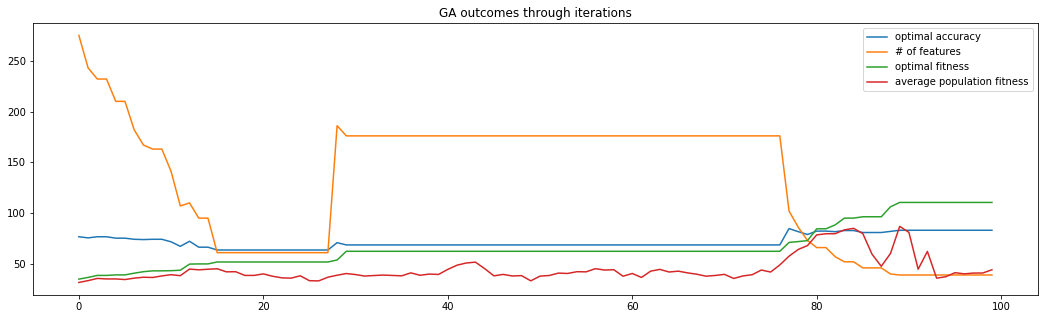

Final solution feature relevance: 
Feature: 2  Score: -0.06864
Feature: 8  Score: 0.16332
Feature: 16  Score: 0.07226
Feature: 20  Score: -0.16918
Feature: 22  Score: -0.23133
Feature: 26  Score: -0.05382
Feature: 30  Score: 0.01545
Feature: 32  Score: -0.03445
Feature: 39  Score: -0.02604
Feature: 49  Score: 0.14922
Feature: 53  Score: -0.08061
Feature: 56  Score: 0.18717
Feature: 57  Score: 0.28648
Feature: 72  Score: 0.16353
Feature: 85  Score: 0.16478
Feature: 86  Score: 0.11398
Feature: 90  Score: -0.00546
Feature: 104  Score: 0.19053
Feature: 108  Score: -0.03148
Feature: 110  Score: -0.15970
Feature: 113  Score: 0.29688
Feature: 115  Score: -0.00941
Feature: 138  Score: -0.07027
Feature: 191  Score: -0.07245
Feature: 249  Score: -0.29570
Feature: 281  Score: 0.00966
Feature: 305  Score: -0.04360
Feature: 313  Score: -0.00513
Feature: 342  Score: -0.01549
Feature: 360  Score: -0.01202
Feature: 417  Score: -0.02015
Feature: 565  Score: 0.00581
Feature: 703  Score: -0.04929
Feature

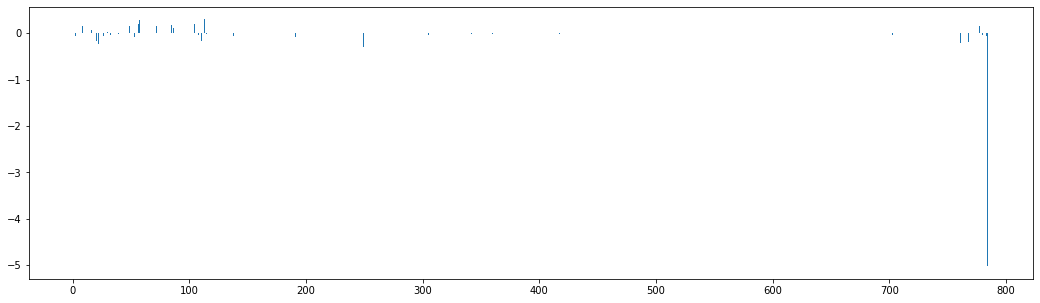

Trial  2
FINAL Optimal Feature Set
 [19, 36, 341, 342, 391, 416, 417, 446, 719, 742, 763, 784]
FINAL Optimal Accuracy = 87.77777777777777 %
Execution time is:  3210.32088303566
Number of selected features is:  12
Number of features selected through iterations: 


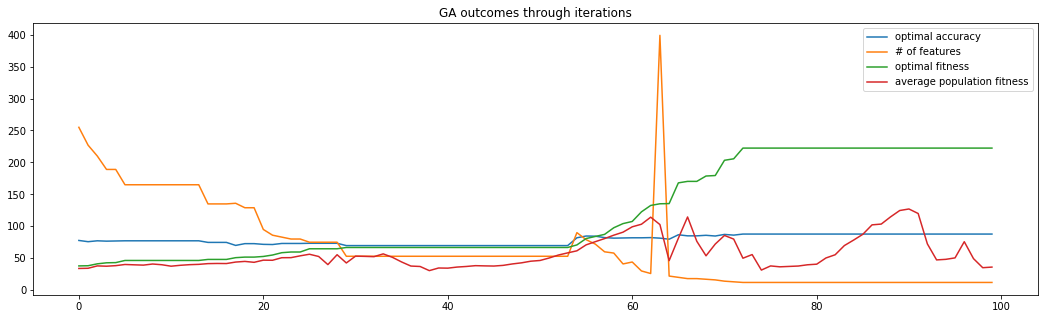

Final solution feature relevance: 
Feature: 19  Score: -0.13535
Feature: 36  Score: -0.00497
Feature: 341  Score: -0.01218
Feature: 342  Score: -0.01751
Feature: 391  Score: -0.00349
Feature: 416  Score: -0.01471
Feature: 417  Score: -0.02571
Feature: 446  Score: -0.01976
Feature: 719  Score: 0.31594
Feature: 742  Score: -0.02513
Feature: 763  Score: -0.02616
Feature: 784  Score: -5.54553


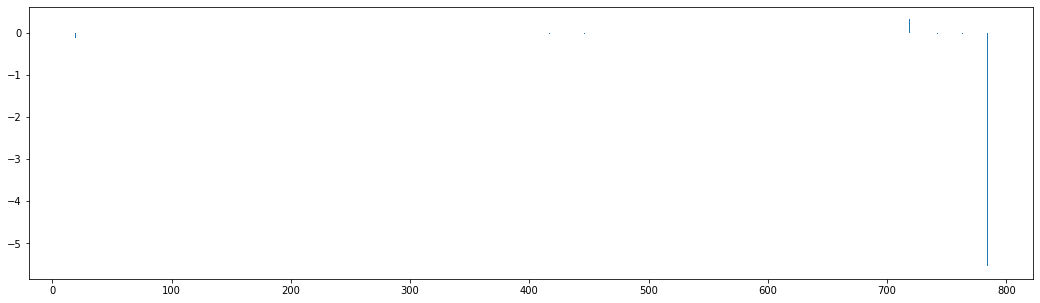

Trial  3
FINAL Optimal Feature Set
 [19, 33, 313, 342, 343, 418, 590, 682, 684, 716, 741, 766, 784]
FINAL Optimal Accuracy = 86.94444444444444 %
Execution time is:  3689.3178601264954
Number of selected features is:  13
Number of features selected through iterations: 


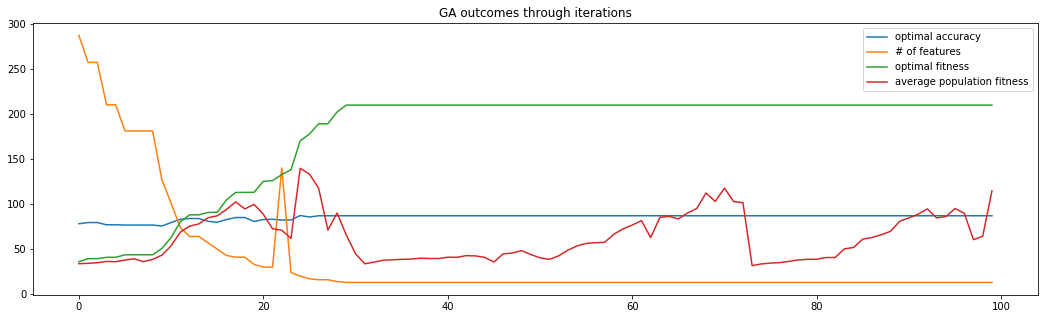

Final solution feature relevance: 
Feature: 19  Score: -0.05615
Feature: 33  Score: -0.00848
Feature: 313  Score: -0.00525
Feature: 342  Score: -0.02051
Feature: 343  Score: -0.00519
Feature: 418  Score: -0.02240
Feature: 590  Score: -0.04800
Feature: 682  Score: 0.01066
Feature: 684  Score: -0.01089
Feature: 716  Score: 0.03477
Feature: 741  Score: -0.04246
Feature: 766  Score: 0.20414
Feature: 784  Score: -5.54731


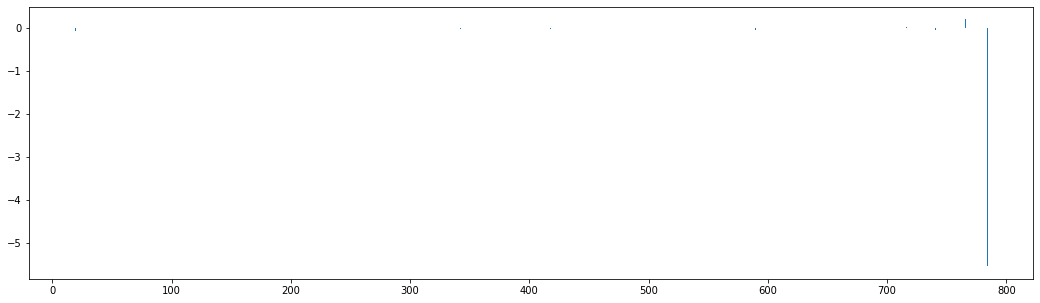

Trial  4
FINAL Optimal Feature Set
 [11, 19, 102, 341, 342, 388, 418, 703, 706, 715, 735, 761, 768, 784]
FINAL Optimal Accuracy = 85.0 %
Execution time is:  4526.3786878585815
Number of selected features is:  14
Number of features selected through iterations: 


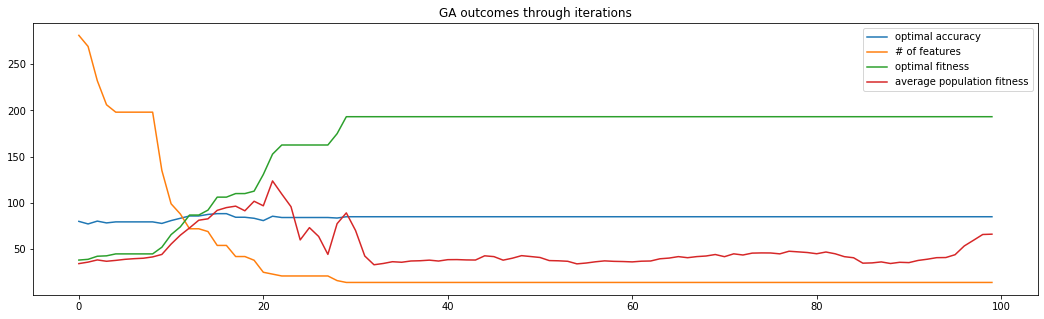

Final solution feature relevance: 
Feature: 11  Score: -0.01958
Feature: 19  Score: -0.10003
Feature: 102  Score: 0.00690
Feature: 341  Score: -0.01120
Feature: 342  Score: -0.01969
Feature: 388  Score: -0.01498
Feature: 418  Score: -0.04729
Feature: 703  Score: -0.01531
Feature: 706  Score: 0.08911
Feature: 715  Score: 0.00552
Feature: 735  Score: 0.28718
Feature: 761  Score: 0.00329
Feature: 768  Score: -0.13223
Feature: 784  Score: -5.65475


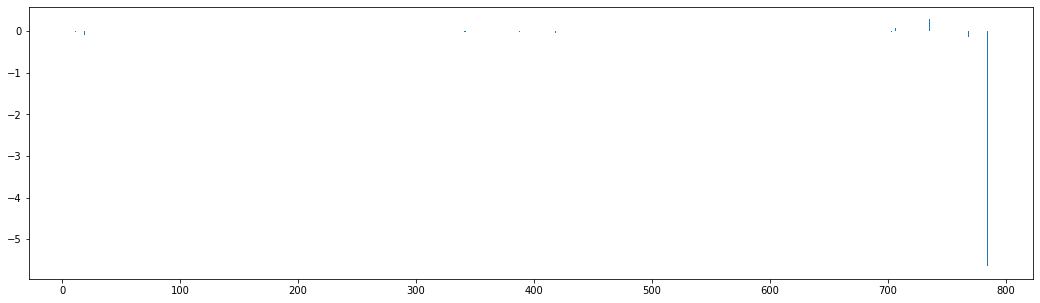

Trial  5
FINAL Optimal Feature Set
 [19, 39, 44, 48, 62, 67, 104, 162, 304, 336, 342, 369, 446, 506, 563, 650, 703, 718, 773, 784]
FINAL Optimal Accuracy = 86.66666666666667 %
Execution time is:  2944.0208230018616
Number of selected features is:  20
Number of features selected through iterations: 


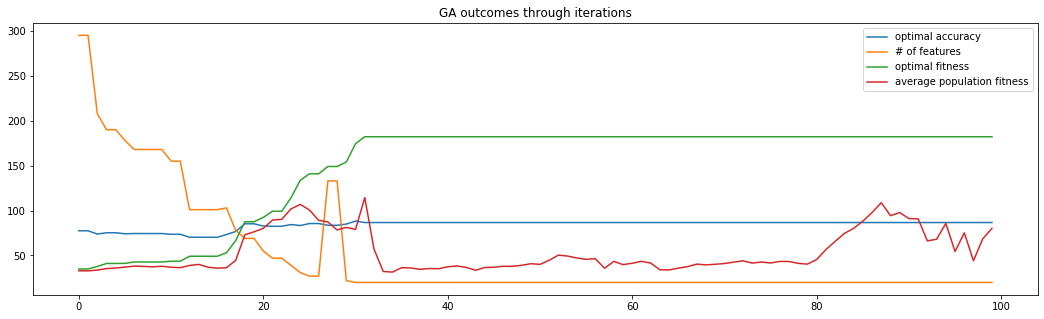

Final solution feature relevance: 
Feature: 19  Score: -0.14022
Feature: 39  Score: 0.02594
Feature: 44  Score: 0.01741
Feature: 48  Score: 0.00410
Feature: 62  Score: -0.03862
Feature: 67  Score: 0.02874
Feature: 104  Score: 0.11246
Feature: 162  Score: -0.02136
Feature: 304  Score: -0.01522
Feature: 336  Score: 0.12313
Feature: 342  Score: -0.01357
Feature: 369  Score: -0.01118
Feature: 446  Score: -0.01258
Feature: 506  Score: 0.00779
Feature: 563  Score: -0.00651
Feature: 650  Score: -0.02846
Feature: 703  Score: -0.14066
Feature: 718  Score: 0.04867
Feature: 773  Score: 0.09028
Feature: 784  Score: -5.35795


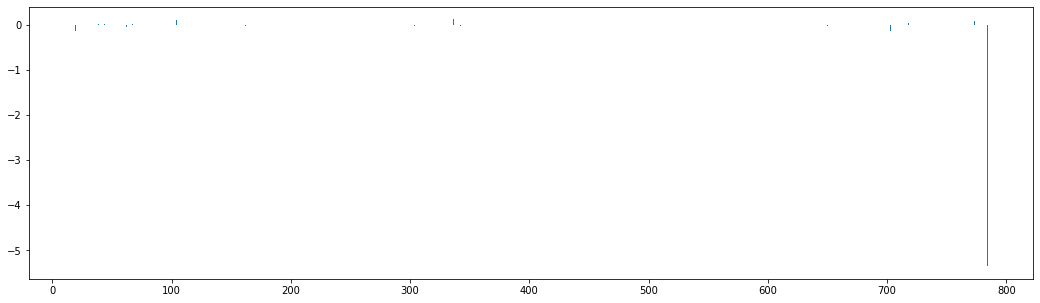

Trial  6
FINAL Optimal Feature Set
 [48, 388, 389, 472, 528, 556, 590, 611, 677, 706, 735, 784]
FINAL Optimal Accuracy = 99.16666666666667 %
Execution time is:  3266.6633291244507
Number of selected features is:  12
Number of features selected through iterations: 


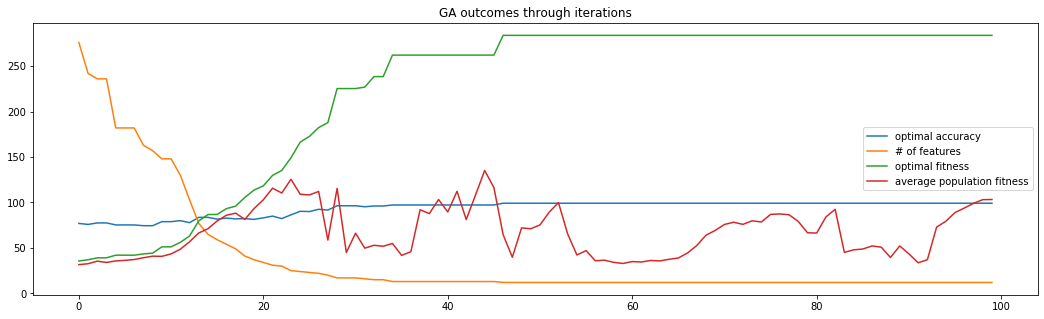

Final solution feature relevance: 
Feature: 48  Score: -0.01018
Feature: 388  Score: -0.00933
Feature: 389  Score: -0.03906
Feature: 472  Score: -0.01362
Feature: 528  Score: -0.01027
Feature: 556  Score: -0.00819
Feature: 590  Score: -0.03048
Feature: 611  Score: -0.05321
Feature: 677  Score: -0.04487
Feature: 706  Score: 0.02647
Feature: 735  Score: 0.22632
Feature: 784  Score: -5.79884


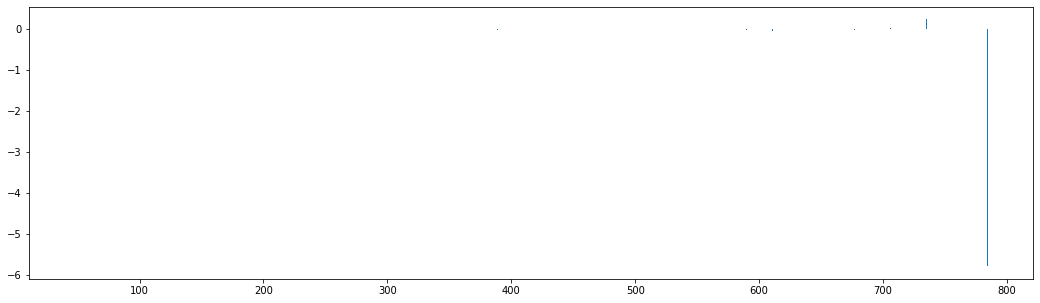

Trial  7
FINAL Optimal Feature Set
 [308, 336, 560, 784]
FINAL Optimal Accuracy = 99.44444444444444 %
Execution time is:  2979.849513053894
Number of selected features is:  4
Number of features selected through iterations: 


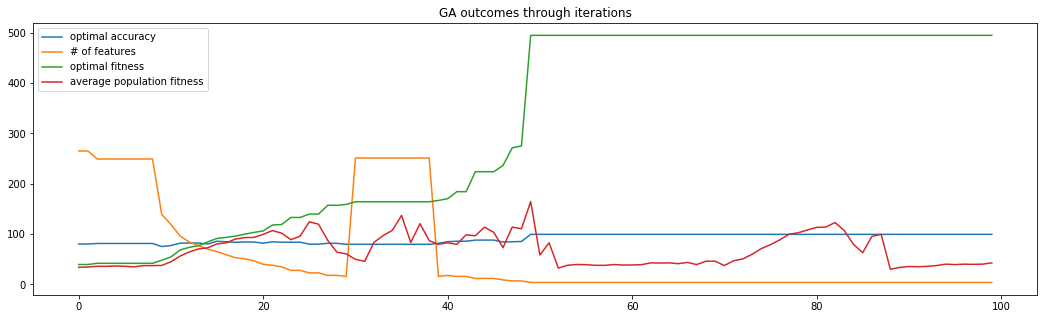

Final solution feature relevance: 
Feature: 308  Score: 0.07639
Feature: 336  Score: -0.06127
Feature: 560  Score: 0.01970
Feature: 784  Score: -5.92865


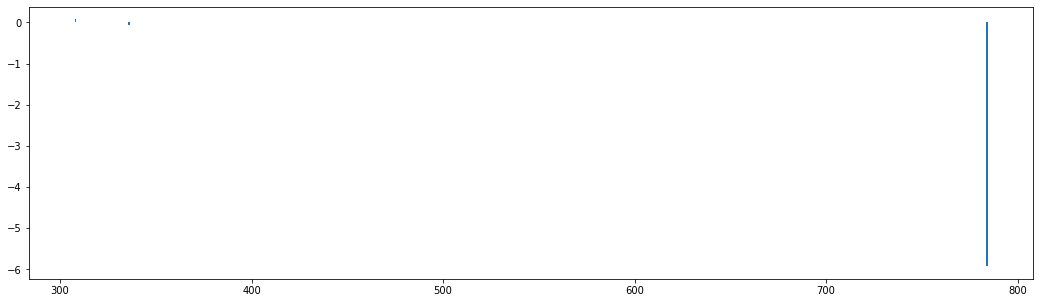

Trial  8
FINAL Optimal Feature Set
 [104, 162, 305, 342, 369, 388, 474, 590, 716, 736, 741, 748, 784]
FINAL Optimal Accuracy = 90.55555555555556 %
Execution time is:  3332.941431045532
Number of selected features is:  13
Number of features selected through iterations: 


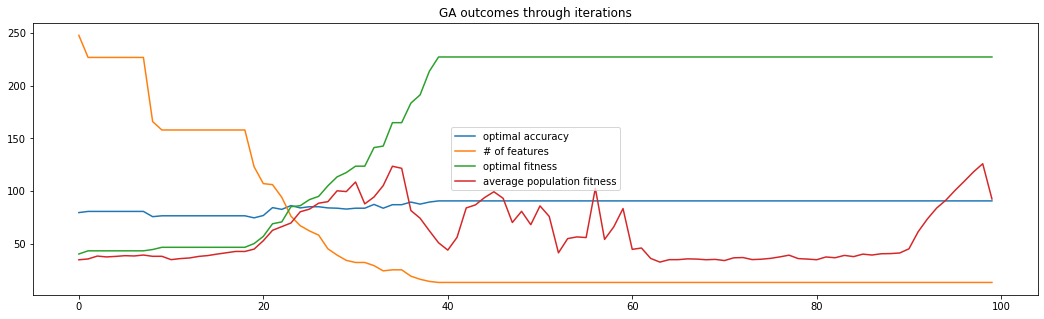

Final solution feature relevance: 
Feature: 104  Score: 0.05072
Feature: 162  Score: -0.01504
Feature: 305  Score: -0.03092
Feature: 342  Score: -0.01634
Feature: 369  Score: -0.01594
Feature: 388  Score: -0.01268
Feature: 474  Score: -0.00822
Feature: 590  Score: -0.04801
Feature: 716  Score: 0.03701
Feature: 736  Score: 0.02789
Feature: 741  Score: -0.05320
Feature: 748  Score: 0.11475
Feature: 784  Score: -5.34777


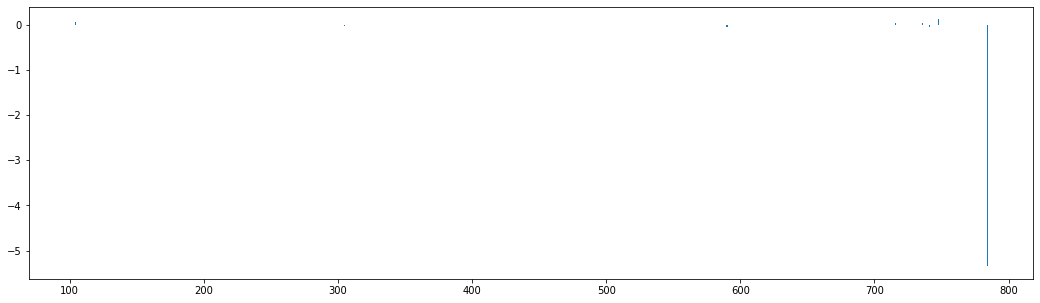

Trial  9
FINAL Optimal Feature Set
 [33, 36, 62, 63, 64, 112, 167, 341, 416, 418, 535, 561, 611, 692, 763, 784]
FINAL Optimal Accuracy = 94.16666666666667 %
Execution time is:  2941.663804769516
Number of selected features is:  16
Number of features selected through iterations: 


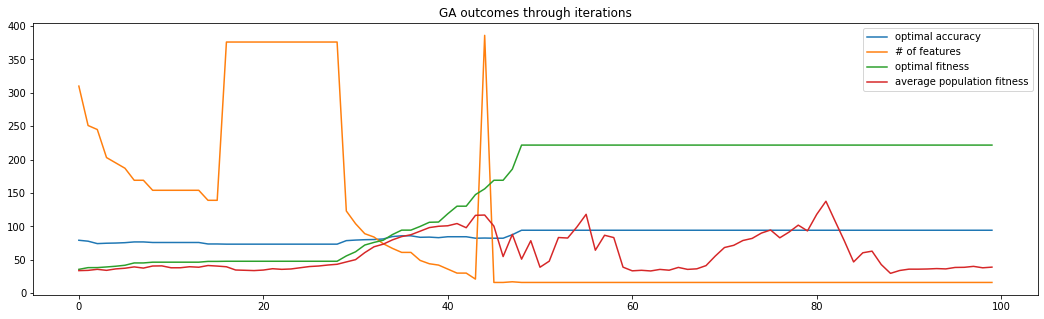

Final solution feature relevance: 
Feature: 33  Score: 0.09518
Feature: 36  Score: -0.06731
Feature: 62  Score: -0.02862
Feature: 63  Score: -0.09918
Feature: 64  Score: 0.10482
Feature: 112  Score: 0.20437
Feature: 167  Score: -0.03819
Feature: 341  Score: -0.01479
Feature: 416  Score: -0.01632
Feature: 418  Score: -0.05516
Feature: 535  Score: 0.00236
Feature: 561  Score: -0.04811
Feature: 611  Score: -0.01558
Feature: 692  Score: 0.01877
Feature: 763  Score: -0.01238
Feature: 784  Score: -5.20379


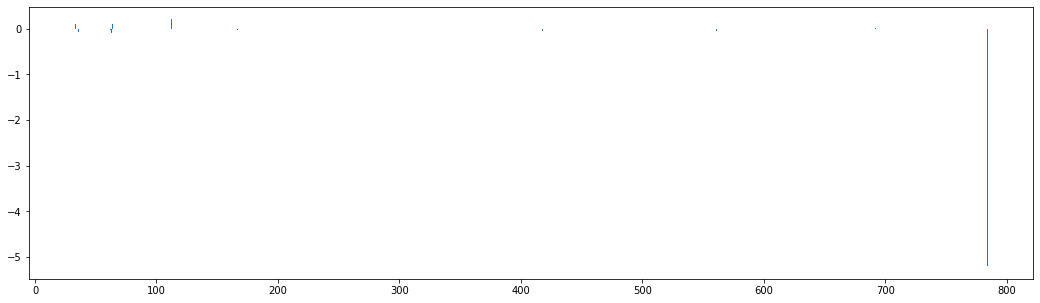

Trial  10
FINAL Optimal Feature Set
 [43, 48, 62, 98, 137, 250, 334, 341, 370, 445, 476, 504, 589, 615, 617, 692, 706, 740, 741, 746, 784]
FINAL Optimal Accuracy = 81.66666666666667 %
Execution time is:  4022.180635213852
Number of selected features is:  21
Number of features selected through iterations: 


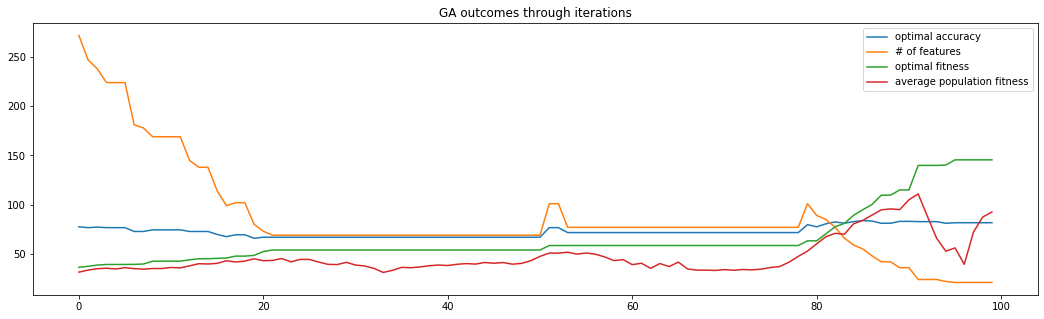

Final solution feature relevance: 
Feature: 43  Score: -0.01511
Feature: 48  Score: -0.04498
Feature: 62  Score: -0.01651
Feature: 98  Score: 0.00637
Feature: 137  Score: -0.01411
Feature: 250  Score: -0.03596
Feature: 334  Score: -0.03119
Feature: 341  Score: -0.01407
Feature: 370  Score: -0.00697
Feature: 445  Score: -0.02215
Feature: 476  Score: -0.01623
Feature: 504  Score: 0.07552
Feature: 589  Score: 0.02643
Feature: 615  Score: -0.21239
Feature: 617  Score: -0.03206
Feature: 692  Score: 0.22697
Feature: 706  Score: 0.20152
Feature: 740  Score: 0.01103
Feature: 741  Score: -0.02493
Feature: 746  Score: -0.03039
Feature: 784  Score: -5.51868


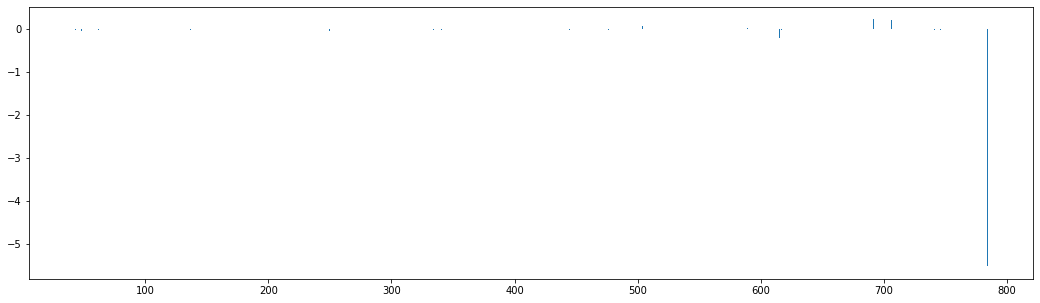

--------------------------------------------------


AttributeError: 'list' object has no attribute 'mean'

In [14]:
ga_multiple_trials(10, df2, feature_list2, target2, 10, 100)

In [16]:
df4 = pd.read_csv("speech.csv")
colmns4 = list(df4.columns.values)
target4 = colmns4.pop()
labels4 = df4[target4]
data4 = df4.drop(target4, axis=1)
feature_list4 = [i for i in df4.columns]

Trial  1
FINAL Optimal Feature Set
 [155, 395, 396, 397, 400, 401, 407]
FINAL Optimal Accuracy = 80.1762114537445 %
Execution time is:  119.56386804580688
Number of selected features is:  7
Number of features selected through iterations: 


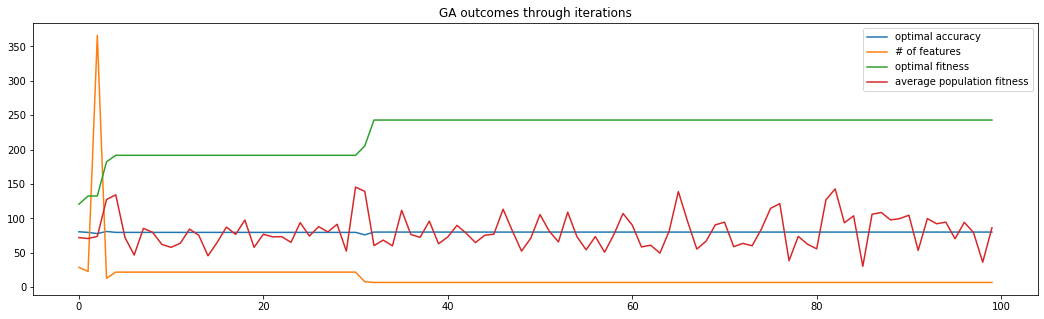

Final solution feature relevance: 
Feature: 155  Score: 0.00000
Feature: 395  Score: 0.00001
Feature: 396  Score: -0.00001
Feature: 397  Score: 0.00000
Feature: 400  Score: -0.00001
Feature: 401  Score: 0.00001
Feature: 407  Score: -0.00003


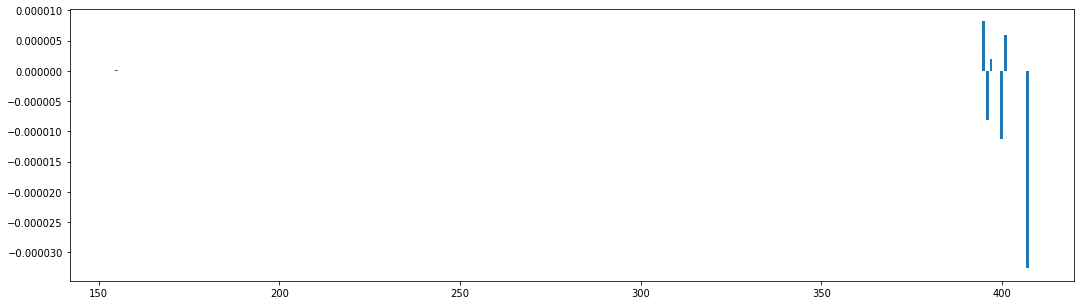

Trial  2
FINAL Optimal Feature Set
 [154, 157, 158, 288, 289, 290, 394, 397, 400, 404, 405, 406]
FINAL Optimal Accuracy = 84.58149779735683 %
Execution time is:  100.899334192276
Number of selected features is:  12
Number of features selected through iterations: 


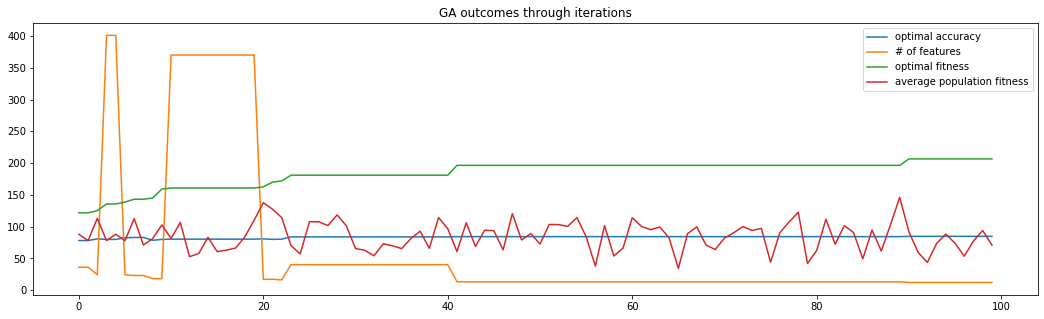

Final solution feature relevance: 
Feature: 154  Score: 0.00000
Feature: 157  Score: -0.00000
Feature: 158  Score: 0.00000
Feature: 288  Score: 0.00004
Feature: 289  Score: 0.00002
Feature: 290  Score: -0.00002
Feature: 394  Score: 0.00000
Feature: 397  Score: -0.00000
Feature: 400  Score: -0.00001
Feature: 404  Score: -0.00000
Feature: 405  Score: -0.00004
Feature: 406  Score: 0.00002


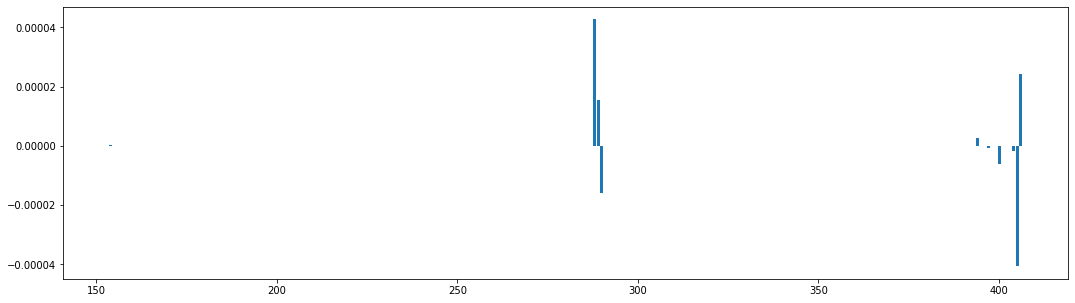

Trial  3
FINAL Optimal Feature Set
 [0, 1, 3, 4, 5, 8, 10, 11, 13, 15, 16, 17, 19, 27, 29, 30, 33, 39, 41, 44, 45, 48, 49, 53, 57, 59, 61, 65, 68, 69, 74, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 95, 96, 97, 101, 103, 105, 106, 111, 112, 113, 118, 119, 120, 121, 125, 127, 133, 134, 135, 136, 139, 141, 144, 145, 146, 147, 149, 150, 151, 152, 155, 157, 159, 160, 161, 162, 164, 167, 169, 170, 172, 173, 174, 176, 177, 178, 182, 184, 186, 187, 188, 189, 191, 194, 197, 198, 199, 200, 204, 205, 209, 213, 214, 215, 218, 219, 221, 222, 225, 226, 230, 233, 234, 235, 238, 240, 242, 245, 246, 247, 250, 253, 257, 260, 262, 264, 265, 266, 267, 268, 269, 272, 275, 280, 281, 287, 290, 291, 292, 294, 295, 296, 302, 303, 307, 308, 311, 312, 323, 325, 326, 327, 329, 331, 333, 334, 338, 340, 343, 344, 345, 348, 352, 355, 356, 357, 359, 361, 362, 366, 367, 369, 371, 372, 374, 375, 376, 377, 379, 380, 381, 384, 385, 386, 387, 389, 390, 393, 394, 395, 396, 397, 399, 400, 402, 403, 404, 406, 408, 411, 414,

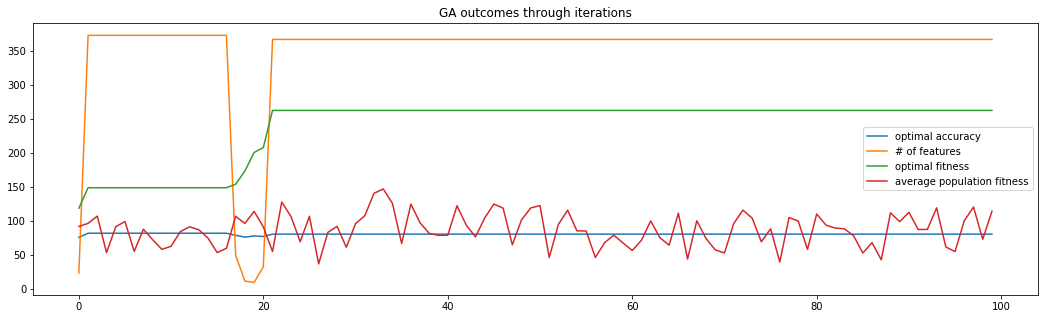

Final solution feature relevance: 
Feature: 0  Score: -0.00000
Feature: 1  Score: 0.00000
Feature: 3  Score: 0.00000
Feature: 4  Score: 0.00000
Feature: 5  Score: -0.00000
Feature: 8  Score: 0.00000
Feature: 10  Score: 0.00000
Feature: 11  Score: 0.00000
Feature: 13  Score: 0.00000
Feature: 15  Score: 0.00000
Feature: 16  Score: 0.00000
Feature: 17  Score: 0.00000
Feature: 19  Score: 0.00000
Feature: 27  Score: -0.00000
Feature: 29  Score: -0.00000
Feature: 30  Score: 0.00000
Feature: 33  Score: -0.00000
Feature: 39  Score: -0.00000
Feature: 41  Score: -0.00000
Feature: 44  Score: 0.00000
Feature: 45  Score: -0.00000
Feature: 48  Score: 0.00000
Feature: 49  Score: -0.00000
Feature: 53  Score: 0.00000
Feature: 57  Score: -0.00000
Feature: 59  Score: 0.00000
Feature: 61  Score: -0.00000
Feature: 65  Score: 0.00000
Feature: 68  Score: 0.00000
Feature: 69  Score: -0.00000
Feature: 74  Score: -0.00000
Feature: 81  Score: -0.00000
Feature: 82  Score: 0.00000
Feature: 83  Score: 0.00000
Featu

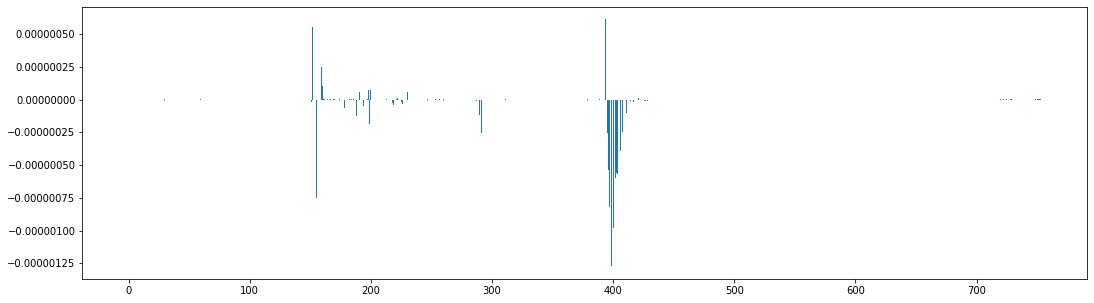

Trial  4
FINAL Optimal Feature Set
 [0, 1, 2, 3, 4, 8, 12, 13, 16, 19, 20, 23, 24, 26, 28, 30, 31, 32, 33, 36, 37, 38, 40, 41, 42, 47, 48, 50, 53, 56, 57, 59, 63, 66, 68, 71, 72, 73, 74, 76, 77, 78, 83, 84, 90, 93, 94, 96, 101, 102, 103, 105, 109, 112, 115, 116, 117, 118, 120, 122, 124, 125, 126, 132, 133, 134, 135, 137, 140, 141, 142, 143, 145, 147, 148, 149, 150, 152, 153, 155, 157, 159, 163, 167, 168, 169, 173, 174, 175, 177, 178, 179, 180, 184, 186, 188, 190, 191, 194, 196, 197, 198, 199, 203, 206, 209, 210, 212, 215, 217, 220, 221, 222, 224, 226, 227, 229, 231, 234, 235, 237, 238, 239, 242, 245, 246, 247, 248, 250, 251, 253, 254, 256, 259, 262, 263, 264, 268, 269, 270, 271, 273, 274, 276, 277, 278, 279, 284, 286, 287, 289, 291, 292, 293, 295, 296, 297, 307, 308, 309, 310, 311, 314, 315, 316, 318, 319, 320, 323, 329, 331, 333, 336, 344, 347, 351, 353, 354, 356, 358, 359, 361, 363, 366, 367, 368, 371, 372, 379, 381, 384, 385, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 400, 40

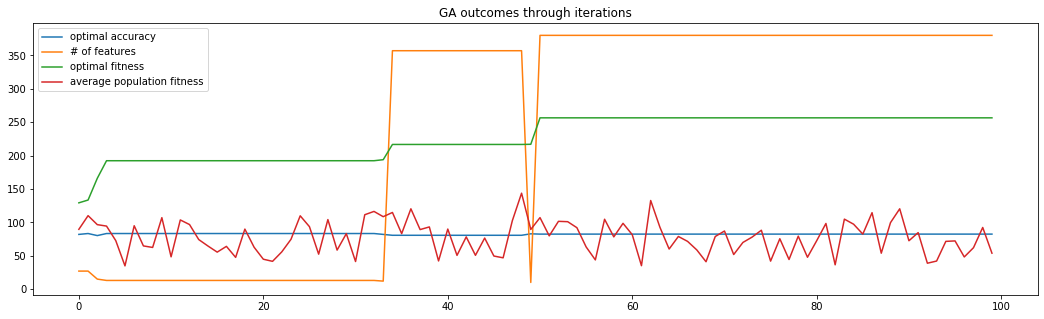

Final solution feature relevance: 
Feature: 0  Score: -0.00000
Feature: 1  Score: 0.00000
Feature: 2  Score: -0.00000
Feature: 3  Score: 0.00000
Feature: 4  Score: 0.00000
Feature: 8  Score: 0.00000
Feature: 12  Score: 0.00000
Feature: 13  Score: 0.00000
Feature: 16  Score: 0.00000
Feature: 19  Score: 0.00000
Feature: 20  Score: -0.00000
Feature: 23  Score: -0.00000
Feature: 24  Score: -0.00000
Feature: 26  Score: -0.00000
Feature: 28  Score: 0.00000
Feature: 30  Score: 0.00000
Feature: 31  Score: 0.00000
Feature: 32  Score: -0.00000
Feature: 33  Score: -0.00000
Feature: 36  Score: 0.00000
Feature: 37  Score: 0.00000
Feature: 38  Score: 0.00000
Feature: 40  Score: -0.00000
Feature: 41  Score: -0.00000
Feature: 42  Score: -0.00000
Feature: 47  Score: -0.00000
Feature: 48  Score: 0.00000
Feature: 50  Score: 0.00000
Feature: 53  Score: 0.00000
Feature: 56  Score: -0.00000
Feature: 57  Score: -0.00000
Feature: 59  Score: 0.00000
Feature: 63  Score: -0.00000
Feature: 66  Score: -0.00000
Fea

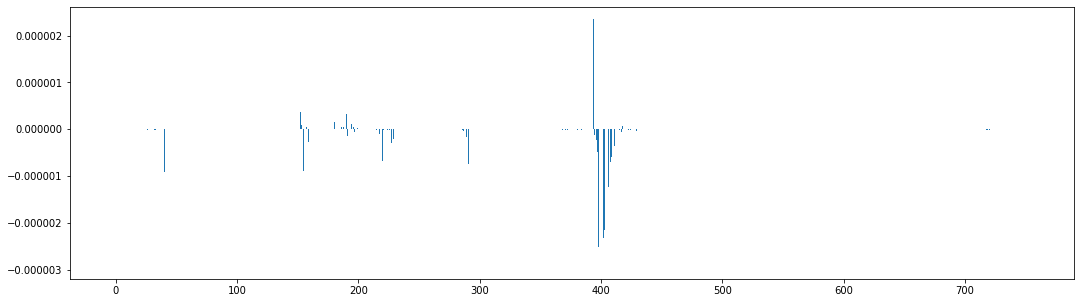

Trial  5
FINAL Optimal Feature Set
 [153, 291, 395, 396, 397, 398, 400, 402]
FINAL Optimal Accuracy = 79.73568281938326 %
Execution time is:  133.17854833602905
Number of selected features is:  8
Number of features selected through iterations: 


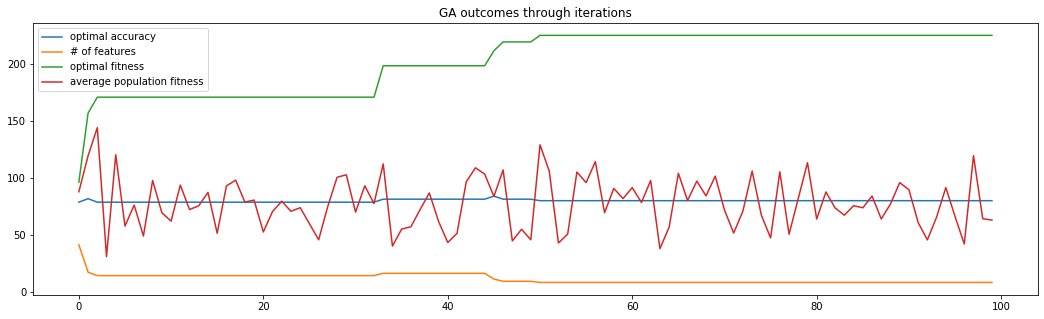

Final solution feature relevance: 
Feature: 153  Score: 0.00000
Feature: 291  Score: 0.00000
Feature: 395  Score: 0.00001
Feature: 396  Score: -0.00002
Feature: 397  Score: 0.00002
Feature: 398  Score: -0.00002
Feature: 400  Score: -0.00000
Feature: 402  Score: -0.00001


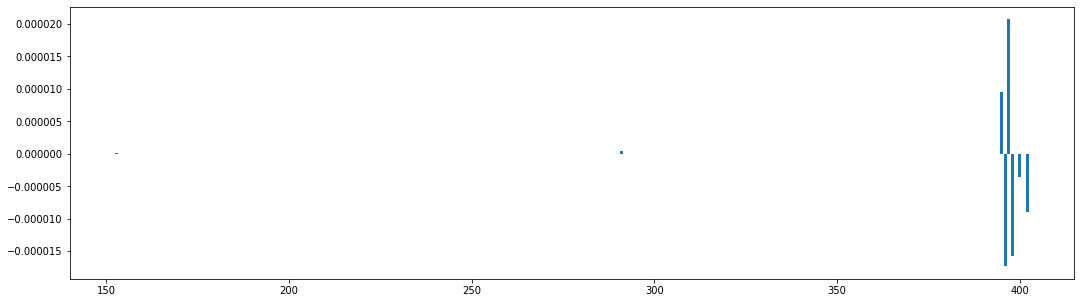

Trial  6
FINAL Optimal Feature Set
 [6, 8, 10, 11, 13, 14, 17, 18, 19, 22, 24, 26, 28, 31, 34, 41, 42, 45, 47, 49, 50, 51, 52, 54, 57, 58, 59, 63, 64, 66, 69, 72, 73, 74, 75, 76, 77, 79, 81, 83, 84, 85, 91, 93, 95, 96, 98, 99, 100, 101, 102, 103, 104, 108, 109, 111, 113, 114, 115, 122, 123, 128, 129, 132, 134, 135, 136, 138, 142, 149, 151, 152, 154, 156, 157, 159, 162, 165, 173, 175, 178, 179, 180, 181, 182, 185, 188, 189, 192, 193, 194, 197, 198, 199, 203, 204, 206, 207, 208, 210, 218, 223, 224, 226, 228, 229, 230, 231, 233, 234, 237, 238, 239, 242, 244, 246, 251, 252, 253, 256, 259, 264, 265, 267, 268, 270, 271, 272, 274, 276, 278, 279, 282, 283, 288, 292, 294, 299, 302, 306, 314, 316, 318, 319, 320, 321, 322, 323, 327, 328, 329, 330, 336, 338, 339, 343, 344, 345, 347, 349, 350, 351, 352, 353, 354, 355, 356, 358, 361, 363, 367, 370, 374, 376, 377, 378, 379, 382, 385, 388, 389, 390, 393, 394, 395, 397, 398, 400, 403, 404, 406, 412, 416, 418, 419, 420, 424, 425, 428, 433, 434, 437, 438

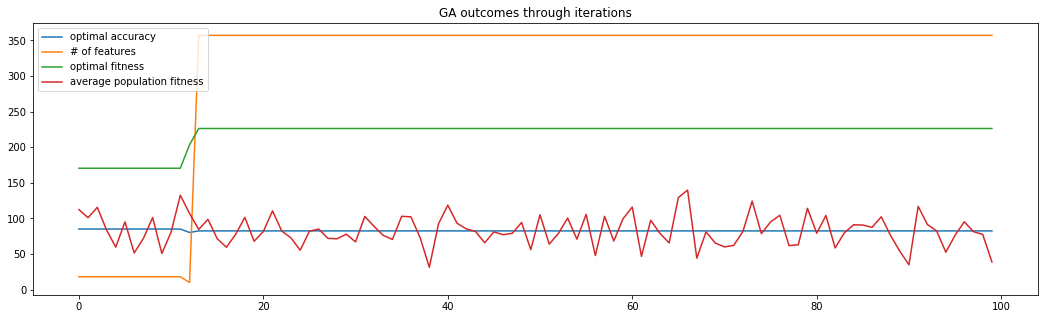

Final solution feature relevance: 
Feature: 6  Score: -0.00000
Feature: 8  Score: 0.00000
Feature: 10  Score: 0.00000
Feature: 11  Score: 0.00000
Feature: 13  Score: 0.00000
Feature: 14  Score: 0.00000
Feature: 17  Score: 0.00000
Feature: 18  Score: 0.00000
Feature: 19  Score: 0.00000
Feature: 22  Score: -0.00000
Feature: 24  Score: -0.00000
Feature: 26  Score: -0.00000
Feature: 28  Score: 0.00000
Feature: 31  Score: 0.00000
Feature: 34  Score: -0.00000
Feature: 41  Score: 0.00000
Feature: 42  Score: 0.00000
Feature: 45  Score: -0.00000
Feature: 47  Score: -0.00000
Feature: 49  Score: 0.00000
Feature: 50  Score: 0.00000
Feature: 51  Score: 0.00000
Feature: 52  Score: 0.00000
Feature: 54  Score: -0.00000
Feature: 57  Score: -0.00000
Feature: 58  Score: -0.00000
Feature: 59  Score: 0.00000
Feature: 63  Score: -0.00000
Feature: 64  Score: 0.00000
Feature: 66  Score: 0.00000
Feature: 69  Score: -0.00000
Feature: 72  Score: -0.00000
Feature: 73  Score: -0.00000
Feature: 74  Score: -0.00000


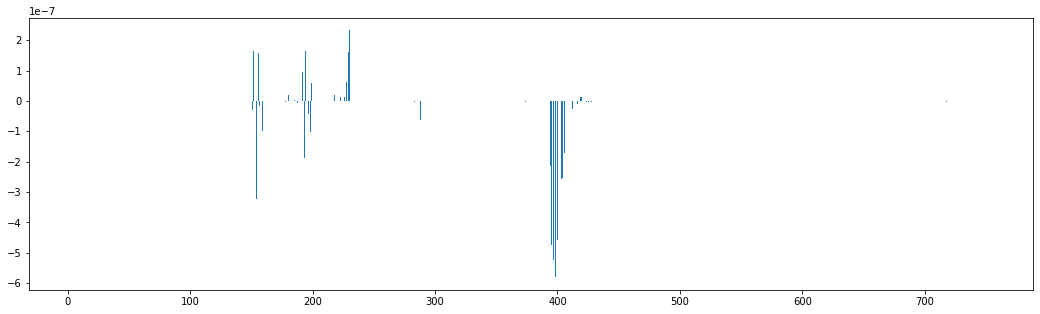

Trial  7
FINAL Optimal Feature Set
 [0, 7, 8, 10, 12, 13, 14, 17, 18, 20, 22, 25, 26, 28, 29, 31, 32, 34, 37, 38, 39, 40, 41, 42, 44, 47, 51, 53, 54, 55, 57, 59, 60, 63, 65, 67, 68, 69, 75, 76, 80, 81, 82, 84, 87, 88, 91, 93, 95, 96, 97, 102, 103, 104, 107, 112, 115, 117, 118, 121, 122, 123, 124, 125, 126, 130, 131, 136, 137, 138, 140, 141, 142, 143, 146, 147, 148, 152, 154, 157, 161, 163, 165, 166, 167, 168, 172, 173, 175, 177, 179, 180, 181, 182, 184, 185, 186, 187, 188, 191, 192, 194, 196, 197, 198, 200, 203, 204, 205, 206, 207, 213, 215, 217, 219, 220, 222, 223, 224, 226, 228, 230, 233, 234, 238, 239, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 258, 259, 260, 261, 262, 263, 266, 267, 269, 270, 275, 276, 280, 284, 285, 288, 289, 291, 292, 293, 294, 296, 298, 300, 303, 304, 305, 307, 310, 311, 314, 316, 317, 319, 322, 323, 324, 328, 329, 335, 339, 340, 341, 342, 344, 346, 348, 351, 353, 358, 365, 366, 367, 372, 373, 374, 376, 378, 380, 381, 386, 390, 391, 39

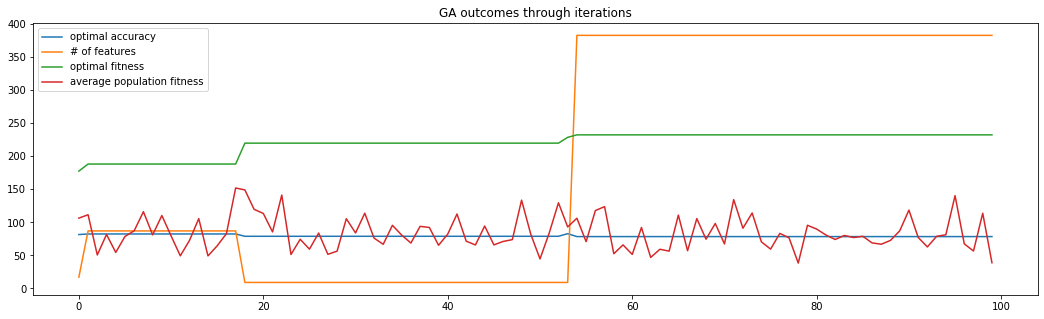

Final solution feature relevance: 
Feature: 0  Score: -0.00000
Feature: 7  Score: -0.00000
Feature: 8  Score: 0.00000
Feature: 10  Score: 0.00000
Feature: 12  Score: 0.00000
Feature: 13  Score: 0.00000
Feature: 14  Score: 0.00000
Feature: 17  Score: 0.00000
Feature: 18  Score: 0.00000
Feature: 20  Score: -0.00000
Feature: 22  Score: -0.00000
Feature: 25  Score: -0.00000
Feature: 26  Score: -0.00000
Feature: 28  Score: 0.00000
Feature: 29  Score: 0.00000
Feature: 31  Score: 0.00000
Feature: 32  Score: -0.00000
Feature: 34  Score: -0.00000
Feature: 37  Score: -0.00000
Feature: 38  Score: 0.00000
Feature: 39  Score: 0.00000
Feature: 40  Score: -0.00000
Feature: 41  Score: 0.00000
Feature: 42  Score: -0.00000
Feature: 44  Score: -0.00000
Feature: 47  Score: -0.00000
Feature: 51  Score: 0.00000
Feature: 53  Score: 0.00000
Feature: 54  Score: -0.00000
Feature: 55  Score: 0.00000
Feature: 57  Score: -0.00000
Feature: 59  Score: 0.00000
Feature: 60  Score: 0.00000
Feature: 63  Score: -0.00000


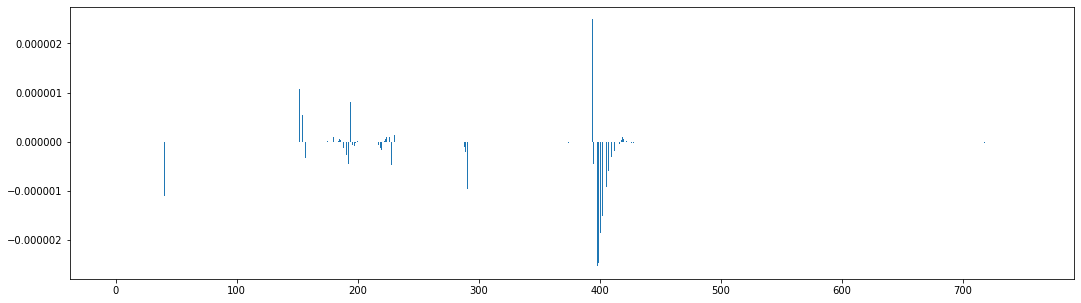

Trial  8
FINAL Optimal Feature Set
 [0, 1, 2, 3, 4, 6, 8, 10, 20, 21, 23, 24, 25, 29, 30, 32, 36, 37, 38, 39, 45, 47, 49, 54, 55, 58, 59, 60, 61, 62, 64, 70, 72, 76, 77, 78, 79, 80, 85, 92, 94, 95, 98, 104, 106, 108, 109, 112, 114, 115, 116, 119, 121, 123, 124, 129, 131, 132, 135, 136, 138, 139, 140, 143, 144, 147, 149, 151, 154, 155, 160, 161, 163, 164, 166, 167, 174, 175, 178, 180, 183, 184, 185, 186, 188, 194, 196, 198, 199, 200, 203, 204, 209, 210, 211, 212, 216, 219, 220, 221, 222, 226, 227, 229, 230, 231, 233, 236, 237, 240, 241, 246, 247, 249, 251, 252, 253, 259, 262, 263, 264, 265, 266, 268, 271, 272, 275, 276, 277, 280, 281, 284, 285, 286, 289, 293, 295, 302, 304, 305, 307, 308, 309, 311, 312, 313, 314, 319, 320, 321, 322, 323, 326, 328, 329, 330, 331, 332, 334, 336, 339, 341, 343, 345, 348, 350, 351, 352, 354, 356, 361, 363, 367, 368, 372, 376, 378, 379, 380, 381, 382, 384, 385, 387, 388, 389, 390, 391, 394, 395, 396, 397, 399, 400, 402, 403, 405, 408, 411, 412, 414, 416, 417

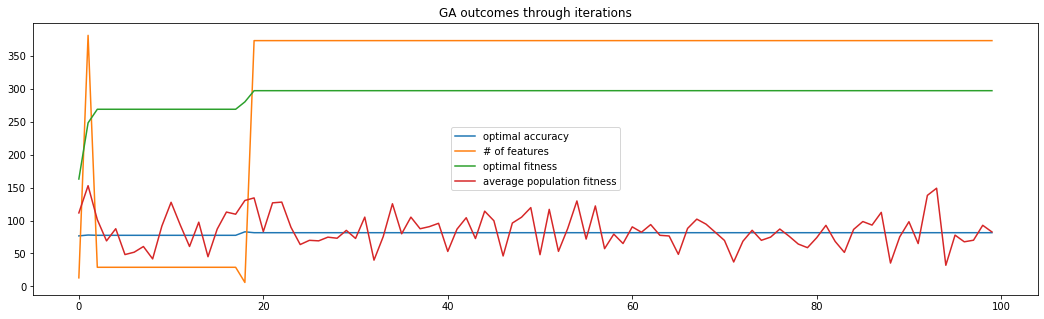

Final solution feature relevance: 
Feature: 0  Score: -0.00000
Feature: 1  Score: 0.00000
Feature: 2  Score: -0.00000
Feature: 3  Score: 0.00000
Feature: 4  Score: 0.00000
Feature: 6  Score: -0.00000
Feature: 8  Score: 0.00000
Feature: 10  Score: 0.00000
Feature: 20  Score: -0.00000
Feature: 21  Score: 0.00000
Feature: 23  Score: -0.00000
Feature: 24  Score: -0.00000
Feature: 25  Score: -0.00000
Feature: 29  Score: 0.00000
Feature: 30  Score: 0.00000
Feature: 32  Score: 0.00000
Feature: 36  Score: 0.00000
Feature: 37  Score: 0.00000
Feature: 38  Score: 0.00000
Feature: 39  Score: -0.00000
Feature: 45  Score: -0.00000
Feature: 47  Score: 0.00000
Feature: 49  Score: -0.00000
Feature: 54  Score: -0.00000
Feature: 55  Score: 0.00000
Feature: 58  Score: -0.00000
Feature: 59  Score: 0.00000
Feature: 60  Score: 0.00000
Feature: 61  Score: -0.00000
Feature: 62  Score: 0.00000
Feature: 64  Score: 0.00000
Feature: 70  Score: -0.00000
Feature: 72  Score: -0.00000
Feature: 76  Score: 0.00000
Featu

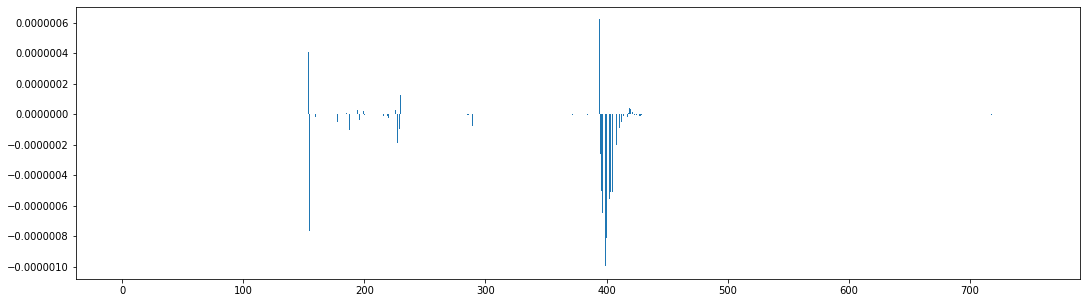

Trial  9
FINAL Optimal Feature Set
 [27, 30, 31, 40, 47, 152, 153, 158, 160, 163, 175, 176, 179, 181, 182, 186, 188, 189, 194, 216, 219, 224, 225, 226, 230, 282, 283, 284, 285, 287, 289, 290, 368, 374, 376, 384, 395, 396, 398, 399, 403, 405, 412, 414, 418, 421, 422, 423, 425, 426, 427, 722, 743, 744]
FINAL Optimal Accuracy = 78.8546255506608 %
Execution time is:  130.90296864509583
Number of selected features is:  54
Number of features selected through iterations: 


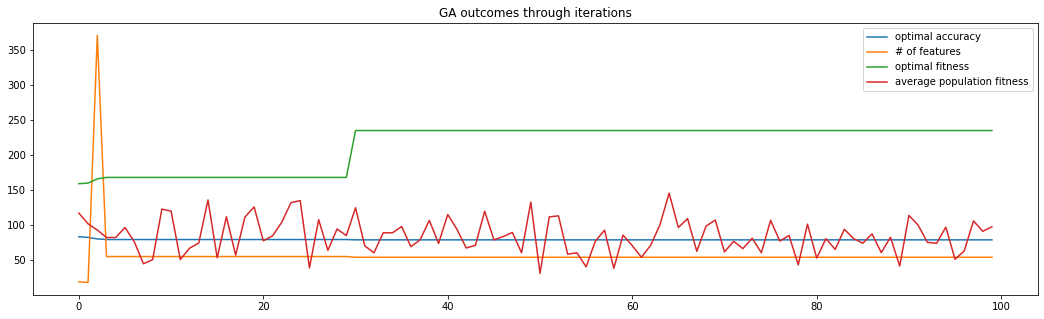

Final solution feature relevance: 
Feature: 27  Score: -0.00000
Feature: 30  Score: -0.00000
Feature: 31  Score: -0.00000
Feature: 40  Score: -0.00000
Feature: 47  Score: -0.00000
Feature: 152  Score: -0.00000
Feature: 153  Score: 0.00000
Feature: 158  Score: 0.00000
Feature: 160  Score: -0.00000
Feature: 163  Score: 0.00000
Feature: 175  Score: 0.00000
Feature: 176  Score: -0.00000
Feature: 179  Score: -0.00000
Feature: 181  Score: 0.00000
Feature: 182  Score: 0.00000
Feature: 186  Score: 0.00001
Feature: 188  Score: 0.00000
Feature: 189  Score: -0.00000
Feature: 194  Score: 0.00000
Feature: 216  Score: 0.00000
Feature: 219  Score: -0.00001
Feature: 224  Score: 0.00001
Feature: 225  Score: 0.00000
Feature: 226  Score: 0.00000
Feature: 230  Score: 0.00000
Feature: 282  Score: 0.00000
Feature: 283  Score: 0.00000
Feature: 284  Score: 0.00000
Feature: 285  Score: 0.00000
Feature: 287  Score: 0.00000
Feature: 289  Score: -0.00000
Feature: 290  Score: 0.00000
Feature: 368  Score: -0.00000


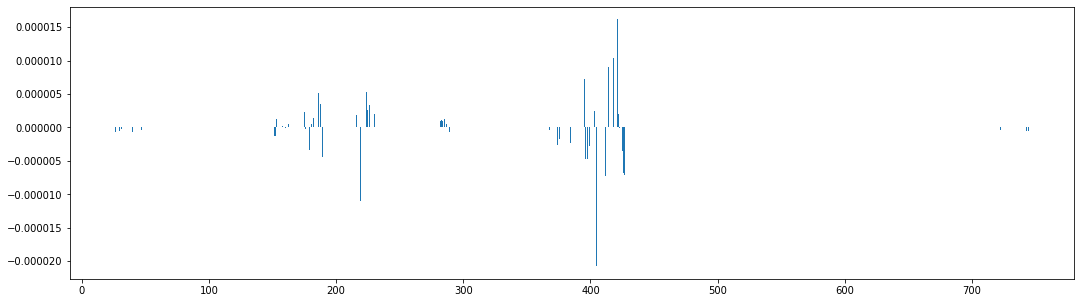

Trial  10
FINAL Optimal Feature Set
 [2, 4, 5, 8, 10, 12, 13, 15, 16, 18, 19, 22, 24, 27, 28, 29, 30, 32, 33, 36, 37, 40, 42, 46, 48, 51, 52, 53, 54, 57, 58, 60, 61, 66, 67, 68, 69, 70, 71, 73, 76, 77, 78, 79, 80, 82, 84, 86, 87, 89, 90, 92, 95, 96, 98, 99, 103, 109, 112, 113, 114, 115, 116, 124, 125, 128, 129, 130, 131, 132, 133, 139, 140, 141, 142, 147, 150, 151, 157, 158, 159, 160, 161, 162, 166, 167, 168, 170, 171, 172, 173, 175, 176, 177, 178, 181, 182, 185, 187, 188, 190, 191, 192, 194, 196, 198, 200, 201, 202, 203, 205, 206, 208, 210, 211, 212, 213, 216, 218, 221, 222, 223, 226, 228, 231, 235, 237, 240, 242, 243, 244, 248, 249, 250, 252, 253, 254, 255, 256, 258, 260, 261, 263, 264, 268, 269, 270, 272, 273, 274, 277, 281, 282, 283, 284, 288, 290, 291, 294, 304, 305, 306, 309, 313, 317, 318, 319, 322, 323, 324, 325, 327, 329, 330, 332, 333, 334, 337, 341, 345, 346, 349, 351, 352, 355, 359, 360, 361, 364, 366, 368, 370, 371, 377, 379, 380, 381, 382, 384, 386, 387, 388, 389, 390, 39

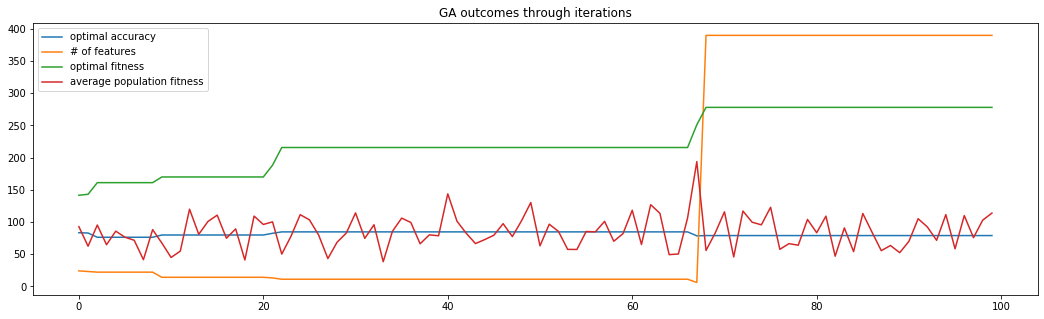

Final solution feature relevance: 
Feature: 2  Score: -0.00000
Feature: 4  Score: 0.00000
Feature: 5  Score: -0.00000
Feature: 8  Score: 0.00000
Feature: 10  Score: 0.00000
Feature: 12  Score: 0.00000
Feature: 13  Score: 0.00000
Feature: 15  Score: 0.00000
Feature: 16  Score: 0.00000
Feature: 18  Score: 0.00000
Feature: 19  Score: 0.00000
Feature: 22  Score: -0.00000
Feature: 24  Score: -0.00000
Feature: 27  Score: -0.00000
Feature: 28  Score: -0.00000
Feature: 29  Score: 0.00000
Feature: 30  Score: 0.00000
Feature: 32  Score: -0.00000
Feature: 33  Score: -0.00000
Feature: 36  Score: 0.00000
Feature: 37  Score: 0.00000
Feature: 40  Score: -0.00000
Feature: 42  Score: 0.00000
Feature: 46  Score: 0.00000
Feature: 48  Score: 0.00000
Feature: 51  Score: -0.00000
Feature: 52  Score: 0.00000
Feature: 53  Score: 0.00000
Feature: 54  Score: -0.00000
Feature: 57  Score: -0.00000
Feature: 58  Score: -0.00000
Feature: 60  Score: 0.00000
Feature: 61  Score: -0.00000
Feature: 66  Score: -0.00000
Fe

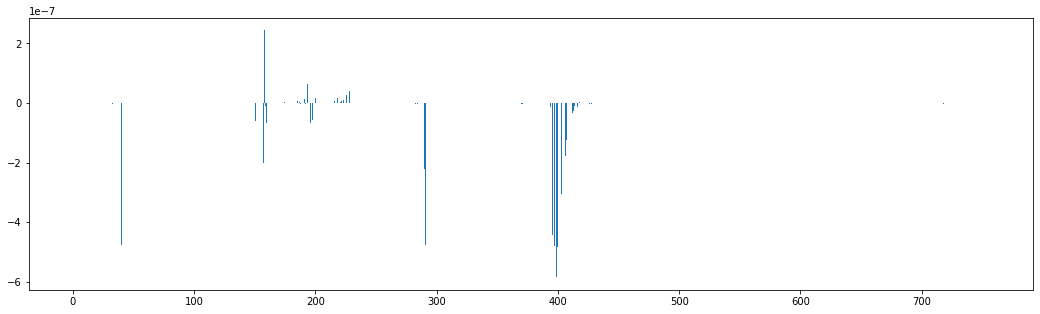

--------------------------------------------------


AttributeError: 'list' object has no attribute 'mean'

In [18]:
ga_multiple_trials(10, df4, feature_list4, target4, 10, 100)